# Quantum Control as Polynomial Optimization: Synthesizing unitary target

This notebook uses multithreadin. Set  

    export JULIA_NUM_THREADS=100
   
before runing Julia

In [1]:
Threads.nthreads()

100

In [2]:
using LinearAlgebra
using QuantumOptics
using DynamicPolynomials
using TSSOS
using QuadGK
using JuMP
using Random
using NLopt

## Quantum system

In [3]:
#= 
Quantum system is taken from 
 https://github.com/q-optimize/c3/blob/master/examples/two_qubits.ipynb

Drift Hamiltonian
=#

H0 = [
    0 0 0;
    0 3.21505101e+10 0;
    0 0 6.23173079e+10
];

H0 ./= norm(H0, Inf)

# Control Hamiltonian
V = [
    0 1 0;
    1 0 1.41421356;
    0 1.41421356 0
]

V ./= norm(V, Inf);

In [4]:
H0

3×3 Matrix{Float64}:
 0.0  0.0       0.0
 0.0  0.515916  0.0
 0.0  0.0       1.0

In [5]:
V

3×3 Matrix{Float64}:
 0.0       0.707107  0.0
 0.707107  0.0       1.0
 0.0       1.0       0.0

## Utilities for working with Polynomials

In [6]:
function ∫(p::AbstractPolynomial, x::PolyVar, x_lower, x_upper)
    
    # get the index of the variable of integration
    ind_x = indexin([x], variables(p))[1]
        
    if isnothing(ind_x)
        # integration valuable is not found among vars
        return p * (x_upper - x_lower)
    end
    
    # get the indefinite integral
    int_p = sum(
        term * x * 1 // (exponents(term)[ind_x] + 1) for term in terms(p)
        init = 0 * x
    )
            
    # get the definite integral
    subs(int_p, x=>x_upper) - subs(int_p, x=>x_lower)
end

function ∫(M::AbstractMatrix, x::PolyVar, x_lower, x_upper)
   map(z -> ∫(z, x, x_lower, x_upper), M) 
end

function real_poly(p::Polynomial)
    #=
    Real part of the polynomial
    =#
    sum(
        real(c) * m for (c, m) in zip(coefficients(p), monomials(p))# if ~isapproxzero(abs(c))
    )
end

function square_frobenius_norm(M::AbstractArray)
    #=
    Square of the Frobenius norm of a matrix
    =#
    real_poly(sum(z' * z for z in M))
end

square_frobenius_norm (generic function with 1 method)

## Get the truncated Magnus expansion ($n=3$)

In [7]:
@polyvar x[1:3]
@polyvar t[1:3]

# final time
const T = 0.5

function u(t, x)
    # the polynomial shape for control
    sum(x[n] * t^(n - 1) for n = 1:length(x))
end

function A(t, x)
    #=
    The generator of motion entering the Magnus expansion
    =#
    (H0 + V * u(t, x)) / im
end

function commutator(a, b)
    a * b - b * a
end 

# get the partial sum of the Magnus expansion
A₁ = A(t[1], x)
A₂ = A(t[2], x)

Ω = ∫(A₁, t[1], 0, T);

# 2nd term in the Magnus expansion
Ω .+= 1//2 * ∫(∫(
    commutator(A₁, A₂), 
    t[2], 0, t[1]), 
    t[1], 0, T
);

# 3nd term in the Magnus expansion

A₃ = A(t[3], x)

Ω .+= 1//6 * ∫(∫(∫(
    commutator(A₁, commutator(A₂, A₃)) + commutator(commutator(A₁, A₂), A₃),
    t[3], 0, t[2]),
    t[2], 0, t[1]),
    t[1], 0, T
);

## Chebyshve polynomial approximation for $\exp_p(\Omega^{(n)}/2)$ with $n=3$ and $p=5$

In [8]:
using SpecialFunctions

"""
Chebyshev approximation for exp(Ω/2)
"""
function exp_chebyshev(Ω::AbstractMatrix, order::Integer)
    
    Tₙ₋₁ = I
    Tₙ  = Ω
    
    # The first two terms of Chebyshev series for exp
    series = besselj(0, 0.5) * Tₙ₋₁ + 2 * besselj(1, 0.5) * Tₙ
    
    for n=2:order
        Tₙ₊₁  = 2 * Ω * Tₙ + Tₙ₋₁
        
        series .+= 2 * besselj(n, 0.5) * Tₙ₊₁
        
        (Tₙ, Tₙ₋₁) = (Tₙ₊₁, Tₙ) 
    end
    
    series
end

Ω = convert(typeof(A₁), Ω)

exp½Ω = exp_chebyshev(Ω, 5);

## Getting statistic for checking the performance of quantum control formulation as a polynomial optimization

In [9]:
function get_unitary(x::AbstractArray)
    #=
    Get the unitary given the coefficients for the polynomial control
    =#
    basis = NLevelBasis(size(H0)[1])

    𝓗₀ = DenseOperator(basis, basis, H0)
    𝓥 = DenseOperator(basis, basis, V)

    H = LazySum([1., u(0, x)], [𝓗₀, 𝓥])
        
    function 𝓗(t, psi)
        H.factors[2] = u(t, x)
        return H
    end

    _, 𝓤 = timeevolution.schroedinger_dynamic([0, T], identityoperator(basis, basis), 𝓗)
    
    return Matrix(𝓤[2].data)
end


function local_minimize(obj::AbstractPolynomial, init_x::AbstractArray)
    #=
    Perform local minimization of obj polynomial using init_x as initial guess
    =#
    vars = variables(obj)

    @assert length(vars) == length(init_x)
    
    function g(a...)
        # Converting polynomial expression to function to be minimize
        obj(vars => a)
    end
    
    model = Model(NLopt.Optimizer)

    set_optimizer_attribute(model, "algorithm", :LD_MMA)

    set_silent(model)
    @variable(model, y[1:length(vars)])

    # set initial guess
    for (var, init_val) in zip(y, init_x)
        set_start_value(var, init_val)
    end

    register(model, :g, length(y), g; autodiff = true)
    @NLobjective(model, Min, g(y...))
    JuMP.optimize!(model)

    map(value, y)
end

local_minimize (generic function with 1 method)

In [10]:
@time begin
    
n_samples = 1000
Random.seed!(6292022)

# randomly generate the coefficients for the polynomial control 
exact_x = -1 .+ 2 * rand(length(x) * n_samples)
exact_x = reshape(exact_x, (length(x), n_samples))

# The values of objective functions for exact x
obj_exact_x = zeros(n_samples)
    
# The array of target unitaries synthesized by the control x
U_targets = zeros(ComplexF64, n_samples, size(H0)...)

# the polynomial objective at min_x
glob_obj_min_x = zeros(n_samples)

# The global minimum via TSSOS library
tssos_glob_obj_min = zeros(n_samples)

# Frobenius norm difference between target and obtained unitaries
norm_U_target_minus_obtained = zeros(n_samples)

# Frobenius norm difference between target and the truncated Magnus expansion
norm_U_target_minus_expΩ_exact_x = zeros(n_samples)
norm_U_target_minus_expΩ_min_x = zeros(n_samples)

# The normalised overlap of the evolution and the target 
f_PSU = zeros(n_samples) 

# Convergence test for the Magnus expansion for the exact control (convergence_test_exact_x < 1)
convergence_test_exact_x = zeros(n_samples)

# Convergence test for the Magnus expansion for the obtained control (convergence_test_min_x < 1)
convergence_test_min_x = zeros(n_samples)

norm_diff_x = zeros(n_samples)

Threads.@threads for i=1:n_samples
    
    # target unitray
    U_targets[i, :, :] = U_target = get_unitary(exact_x[:, i])
        
    # get the polynomial objective function
    obj = square_frobenius_norm(
        exp½Ω' *  U_target - exp½Ω
    )
    
    # save the value of objective function for exact x
    obj_exact_x[i] = obj(exact_x[:, i])
  
    
    # Get the global minimum via TSSOS library
    opt,sol,data = tssos_first(obj, variables(obj); QUIET = true, solution = true)
    
    previous_sol = sol
    previous_opt = opt
    
    while ~isnothing(sol)
        previous_sol = sol
        previous_opt = opt
            
        opt,sol,data = tssos_higher!(data; QUIET = true, solution = true)
    end
    
    tssos_glob_obj_min[i] = previous_opt
    min_x = previous_sol
    
    # refine the estimate by local minimization
    #min_x = local_minimize(obj, min_x)
    
    # the polynomial objective at min_x
    glob_obj_min_x[i] = tssos_glob_obj_min[i]
        
    # get the Frobenius norm difference between target and obtained unitaries
    U_star = get_unitary(min_x)
    norm_U_target_minus_obtained[i] = norm(U_target - U_star)

    # The normalised overlap of the evolution and the target 
    f_PSU[i] = abs(tr(U_target' * U_star)) / size(U_star)[1]
        
    # check the accuracy of the Magnus expansion
    Ω_exact_x = convert(Matrix{ComplexF64}, subs(Ω, x=>exact_x[:, i]))
    norm_U_target_minus_expΩ_exact_x[i] = norm(U_target - exp(Ω_exact_x))

    Ω_min_x = convert(Matrix{ComplexF64}, subs(Ω, x=>min_x))
    norm_U_target_minus_expΩ_min_x[i] = norm(U_target - exp(Ω_min_x))
    
    # Convergence test for the Magnus expansion for the exact control
    convergence_test_exact_x[i] = quadgk(t -> opnorm(A(t, exact_x[:, i])), 0, T)[1] / π

    # Convergence test for the Magnus expansion for the obtained control
    convergence_test_min_x[i] = quadgk(t -> opnorm(A(t, min_x)), 0, T)[1] / π    
    
    norm_diff_x[i] = norm(exact_x[:, i] - min_x)
end
    
end

*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
*********************************** TSSOS ***********************************
*********************************** TSSOS ***********************************
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
TSSOS is launching...
*********************************** TSSOS ***********************************
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ********

optimum = 2.7162539974018997e-8
No higher TS step of the TSSOS hierarchy!
No higher TS step of the TSSOS hierarchy!
optimum = 3.976256557653327e-8
Global optimality certified with relative optimality gap 0.000003%!
No higher TS step of the TSSOS hierarchy!
optimum = 2.0086789068235825e-8
No higher TS step of the TSSOS hierarchy!
No higher TS step of the TSSOS hierarchy!
optimum = 2.7849492628724398e-8
Global optimality certified with relative optimality gap 0.000001%!
optimum = 1.0385059595490012e-8
No higher TS step of the TSSOS hierarchy!
Global optimality certified with relative optimality gap 0.000004%!
No higher TS step of the TSSOS hierarchy!
Global optimality certified with relative optimality gap 0.000003%!
optimum = 1.2954064672857318e-8
optimum = 3.2115518505721716e-8
No higher TS step of the TSSOS hierarchy!
optimum = 1.1526148715087061e-8
Global optimality certified with relative optimality gap 0.000004%!
optimum = 3.0347354105895286e-8
Global optimality certified with rela

optimum = 5.1543387091298566e-8
optimum = 1.6713628718400124e-7
optimum = 5.5708520497241327e-8
optimum = 1.8239947280657382e-8
optimum = 2.0997518378524693e-8
optimum = 1.2493671443361184e-8
Global optimality certified with relative optimality gap 0.000001%!
optimum = 1.2729549449499852e-8
optimum = 1.2672251084808196e-7
optimum = 1.4310242821686775e-8
optimum = 1.0969743489558212e-7
optimum = 1.3523770492324754e-8
optimum = 3.477927220793813e-8
Global optimality certified with relative optimality gap 0.000005%!
optimum = 1.3917612323313872e-8
optimum = 4.311315330714611e-8
Global optimality certified with relative optimality gap 0.000003%!
optimum = 1.4531058583732668e-8
optimum = 3.309984872911717e-8
Global optimality certified with relative optimality gap 0.000002%!
Global optimality certified with relative optimality gap 0.000016%!
No higher TS step of the TSSOS hierarchy!
Global optimality certified with relative optimality gap 0.000002%!
optimum = 1.3943699969622245e-8
Global op

*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by 

optimum = 2.3858400742857635e-8
No higher TS step of the TSSOS hierarchy!
No higher TS step of the TSSOS hierarchy!
optimum = 3.240115301054813e-8
No higher TS step of the TSSOS hierarchy!
Global optimality certified with relative optimality gap 0.000002%!
Global optimality certified with relative optimality gap 0.000003%!
optimum = 8.454650496966126e-9
No higher TS step of the TSSOS hierarchy!
optimum = 1.904741505749208e-8
optimum = 1.2769391067356001e-8
optimum = 3.103013950386518e-8
optimum = 7.746498076115721e-9
optimum = 2.0179503039957585e-8
optimum = 1.4428216573985677e-8
No higher TS step of the TSSOS hierarchy!
Global optimality certified with relative optimality gap 0.000002%!
optimum = 1.5641030568651884e-8
Global optimality certified with relative optimality gap 0.000001%!
optimum = 2.4702400987006816e-8
optimum = 3.7078074059212473e-8
optimum = 1.9376228112068475e-8
optimum = 1.4770286505110872e-8
optimum = 1.5154860066788714e-8
optimum = 8.435421284194449e-8
optimum = 2.

*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by 

optimum = 3.5725027034020135e-8
optimum = 2.0415742303115415e-8
No higher TS step of the TSSOS hierarchy!
No higher TS step of the TSSOS hierarchy!
Global optimality certified with relative optimality gap 0.000003%!
Global optimality certified with relative optimality gap 0.000002%!
No higher TS step of the TSSOS hierarchy!
No higher TS step of the TSSOS hierarchy!
optimum = 2.327209971497241e-8
optimum = 3.31991830489731e-8
optimum = 2.031405235708479e-8
Global optimality certified with relative optimality gap 0.000003%!
Global optimality certified with relative optimality gap 0.000002%!
No higher TS step of the TSSOS hierarchy!
Global optimality certified with relative optimality gap 0.000002%!
No higher TS step of the TSSOS hierarchy!
No higher TS step of the TSSOS hierarchy!
optimum = 1.7847960379317407e-8
optimum = 1.3958423070232004e-8
optimum = 1.543462933184732e-8
optimum = 1.9136590939158695e-8
optimum = 2.956839740020986e-8
optimum = 5.968737563097857e-9
optimum = 1.289925494

*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by 

optimum = 1.4781860801452382e-8
optimum = 2.987721102303312e-8
Global optimality certified with relative optimality gap 0.000001%!
Global optimality certified with relative optimality gap 0.000003%!
optimum = 3.2836304772855004e-8
No higher TS step of the TSSOS hierarchy!
Global optimality certified with relative optimality gap 0.000003%!
optimum = 1.9101626138933022e-8
No higher TS step of the TSSOS hierarchy!
No higher TS step of the TSSOS hierarchy!
Global optimality certified with relative optimality gap 0.000002%!
optimum = 4.5330951104436626e-8
No higher TS step of the TSSOS hierarchy!
Global optimality certified with relative optimality gap 0.000004%!
optimum = 3.488500381567442e-8
No higher TS step of the TSSOS hierarchy!
Global optimality certified with relative optimality gap 0.000003%!
No higher TS step of the TSSOS hierarchy!
optimum = 4.919453156271589e-8
Global optimality certified with relative optimality gap 0.000004%!
No higher TS step of the TSSOS hierarchy!
optimum =

*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
No higher TS step of the TSSOS hierarchy!
Global optimality certified with relative optimality gap 0.000001%!
No higher TS step of the TSSOS hierarchy!
No higher TS step of the TSSOS hierarchy!
No higher TS step of the TSSOS hierarchy!
No higher TS step of the TSSOS hierarchy!
Global optimality certified with relative optimality gap 0.000001%!
No higher TS step of the TSSOS hierarchy!
No higher TS step of the TSSOS hierarchy!
No higher TS step of the TSSOS hierarchy!
No higher TS step of the TSSOS hierarchy!
No higher TS step of the TSSOS hierarchy!
Global optimality certified with relative optimality gap 0.000003%!
Global optimality certified with relative optimality gap 0.000002%!
No higher TS step of the TSSOS hierarchy!
Global optimality certified with relative optimality gap 0.000002%!
No higher TS step of the TSSOS hierarchy!
No high

optimum = 2.4507019735927297e-8
Global optimality certified with relative optimality gap 0.000002%!
No higher TS step of the TSSOS hierarchy!
optimum = 4.5013591948150616e-8
Global optimality certified with relative optimality gap 0.000004%!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
No higher TS step of the TSSOS hierarchy!
optimum = 2.198665790831033e-8
optimum = 3.092164712798927e-8
optimum = 3.20862012466383e-8
Global optimality certified with relative optimality gap 0.000002%!
Global optimality certified with relative optimality gap 0.000003%!
Global optimality certified with relative optimality gap 0.000003%!
No higher TS step of the TSSOS hierarchy!
No higher TS step of the TSSOS hierarchy!
No higher TS step of the TSSOS hierarchy!
optimum = 1.4810288349979938e-8
optimum = 3.526488910265203e-8
Global optimality certified with relative optimality gap 0.000001%!
optimum = 1.34

optimum = 4.878250182040418e-8
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS *********************************

*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
**********************

*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = 2.5169433722732478e-8
optimum = 2.0018839675072107e-8
optimum = 3.187044674715777e-8
optimum = 4.620245789997997e-8
optimum = 2.16323634229712e-8
optimum = 2.371753115705036e-8
optimum = 2.203638905125607e-8
optimum = 2.1686789035530018e-8
optimum = 8.512056618628824e-9
optimum = 1.8976351771005994e-7
optimum = 1.4829846125176572e-7
optimum = 3.5932822562511845e-8
optimum = 3.026230659189216

optimum = 4.102274055633843e-8
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = 3.420986634555124e-8
Global optimality certified with relative optimality gap 0.000004%!
No higher TS step of the TSSOS hierarchy!
Global optimality certified with relative optimality gap 0.000003%!
optimum = 2.950775796375324e-8
No higher TS step of the TSSOS hierarchy!
Global optimality certified with relative optimality gap 0.000003%!
optimum = 3.772969322719169e-8
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = 1.4127214754830941e-8
optimum = 1.2097302695536854e-8
optimum = 8.489473910822998e-9
Global optimality certified with relative optimality gap 0.000001%!
Global optimality certified with relative o

optimum = 4.008237379617043e-8
optimum = 2.6794532065245938e-8
optimum = 1.4846542322803636e-8
optimum = 1.342051539570878e-8
optimum = 2.669205330200816e-8
optimum = 1.2299889227578328e-8
optimum = 2.9205330035136996e-8
optimum = 4.1518138907134004e-8
optimum = 1.812414846200079e-8
optimum = 2.6311917450324422e-8
optimum = 4.066918500935769e-8
optimum = 1.1900151450686112e-7
optimum = 2.474569447670884e-8
optimum = 2.0349169518622336e-8
optimum = 2.749646082380291e-8
optimum = 8.142808408441207e-9
optimum = 5.8928130795199426e-8
optimum = 2.0496856518958017e-8
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = 4.3557194401589144e-7
optimum = 1.7961747398238867e-8
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = 3.5900611720558385e-8
optimum = 3.0664384531236075e-8
optimu

optimum = 7.604533359704842e-9
Global optimality certified with relative optimality gap 0.000001%!
No higher TS step of the TSSOS hierarchy!
optimum = 2.9158960697632817e-8
optimum = 2.811152495614661e-8
optimum = 1.503304940147468e-8
optimum = 1.813137574090276e-8
Global optimality certified with relative optimality gap 0.000003%!
Global optimality certified with relative optimality gap 0.000003%!
No higher TS step of the TSSOS hierarchy!Global optimality certified with relative optimality gap 0.000001%!
Global optimality certified with relative optimality gap 0.000002%!

No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
No higher TS step of the TSSOS hierarchy!
No higher TS step of the TSSOS hierarchy!
optimum = 3.5025374260324404e-8
optimum = 2.68860234764166e-8
optimum = 4.384838786000266e-8
optimum = 1.862102516194328e-8
Global optimality cer

Global optimality certified with relative optimality gap 0.000002%!
Global optimality certified with relative optimality gap 0.000003%!
Global optimality certified with relative optimality gap 0.000001%!
Global optimality certified with relative optimality gap 0.000001%!
Global optimality certified with relative optimality gap 0.000001%!
Global optimality certified with relative optimality gap 0.000001%!
Global optimality certified with relative optimality gap 0.000001%!
Global optimality certified with relative optimality gap 0.000005%!
Global optimality certified with relative optimality gap 0.000001%!
Global optimality certified with relative optimality gap 0.000002%!
Global optimality certified with relative optimality gap 0.000010%!
Global optimality certified with relative optimality gap 0.000009%!
Global optimality certified with relative optimality gap 0.000005%!
Global optimality certified with relative optimality gap 0.000023%!
Global optimality certified with relative optima

Global optimality certified with relative optimality gap 0.000003%!
Global optimality certified with relative optimality gap 0.000002%!
Global optimality certified with relative optimality gap 0.000001%!
Global optimality certified with relative optimality gap 0.000003%!
Global optimality certified with relative optimality gap 0.000002%!
Global optimality certified with relative optimality gap 0.000001%!
Global optimality certified with relative optimality gap 0.000003%!
Global optimality certified with relative optimality gap 0.000001%!
Global optimality certified with relative optimality gap 0.000001%!
Global optimality certified with relative optimality gap 0.000002%!
Global optimality certified with relative optimality gap 0.000002%!
Global optimality certified with relative optimality gap 0.000003%!
Global optimality certified with relative optimality gap 0.000003%!
Global optimality certified with relative optimality gap 0.000002%!
Global optimality certified with relative optima

## Saving results

In [11]:
using HDF5


h5open("results.hdf5", "w") do fid
    fid["U_targets"] = U_targets
    fid["exact_x"] = exact_x
    fid["obj_exact_x"] = obj_exact_x
    fid["tssos_glob_obj_min"] = tssos_glob_obj_min
    fid["norm_U_target_minus_obtained"] = norm_U_target_minus_obtained
    fid["f_PSU"] = f_PSU
    fid["convergence_test_exact_x"] = convergence_test_exact_x
    fid["convergence_test_min_x"] = convergence_test_min_x
end;

## Analysis

In [12]:
using PyPlot

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


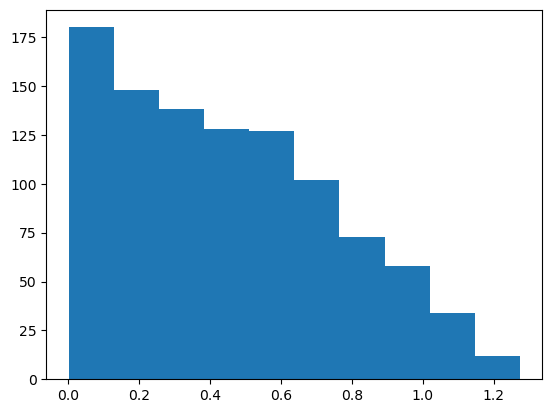

In [13]:
hist(norm_diff_x)
show()

### Actual global minimum vs global minimum estimate via TSSOS

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


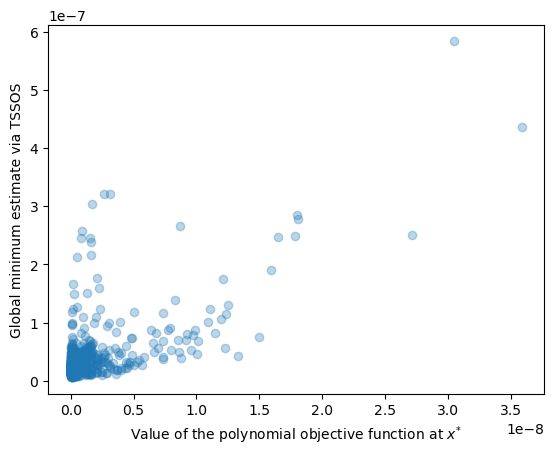

In [14]:
scatter(obj_exact_x, glob_obj_min_x, alpha=0.3)

#lower = min(minimum(obj_exact_x), minimum(glob_obj_min_x))
#higher = maximum(obj_exact_x)
#plot!([lower, higher], [lower, higher], label=nothing)

xlabel("Value of the polynomial objective function at " * L"x^{*}")
ylabel("Global minimum estimate via TSSOS")

savefig("Fig_TSSOSvsXstar.pdf")

show()

### Obtained unitray $\hat{U}$ vs the target $U^{\star}$

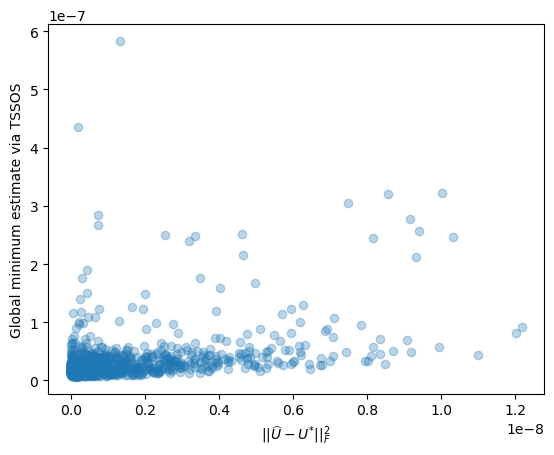

In [15]:
scatter(norm_U_target_minus_obtained .^ 2, glob_obj_min_x, alpha=0.3)
#lower = min(minimum(norm_U_target_minus_obtained .^ 2), minimum(glob_obj_min_x))
#higher = maximum(norm_U_target_minus_obtained .^ 2)
#plot!([lower, higher], [lower, higher], label=nothing)
xlabel(L"\|\| \widehat{U} - U^{*} \|\|_F^2" )
ylabel("Global minimum estimate via TSSOS")
#savefig("Fig_PolynomialOptVsCoherenControl.pdf")
show()

### Infidelity vs the norm difference

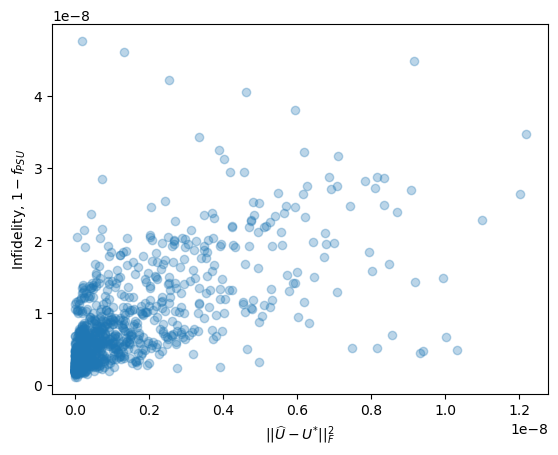

In [16]:
scatter(norm_U_target_minus_obtained .^ 2, 1 .- f_PSU, alpha=0.3)
xlabel(L"\|\| \widehat{U} - U^{*} \|\|_F^2" )
ylabel("Infidelity, " * L"1 - f_{PSU}")
show()

### Testing approximated exp vs exact exp

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


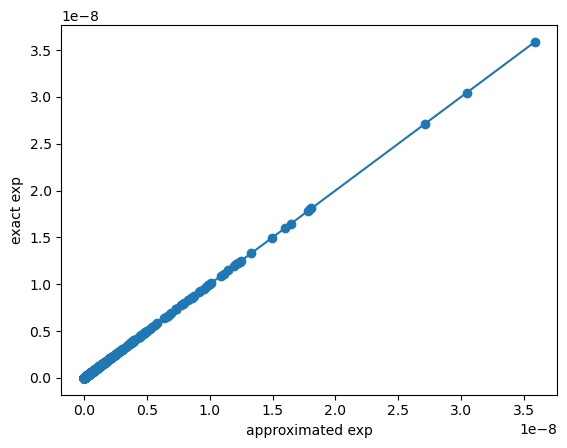

In [17]:
scatter(obj_exact_x, norm_U_target_minus_expΩ_exact_x .^ 2, label=nothing)
lower = min(minimum(norm_U_target_minus_expΩ_exact_x .^ 2), minimum(obj_exact_x))
higher = max(maximum(norm_U_target_minus_expΩ_exact_x .^ 2), maximum(obj_exact_x))
plot([lower, higher], [lower, higher], label=nothing)
xlabel("approximated exp")
ylabel("exact exp")
show()

### Convergence tests

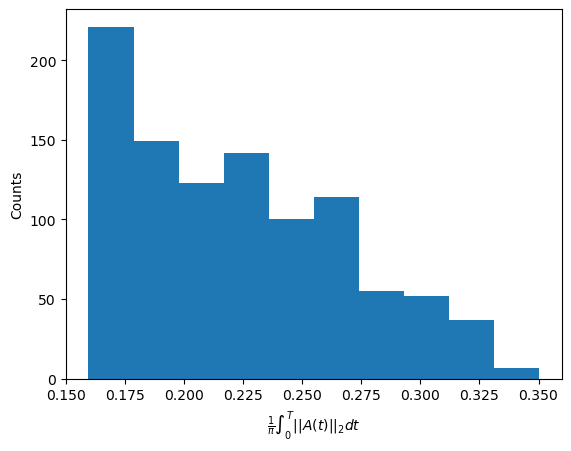

In [18]:
hist(convergence_test_exact_x)
ylabel("Counts")
xlabel(L"\frac{1}{\pi} \int_0^T || A(t) ||_2 dt") #, guidefontsize=11,)
#annotate([(0.35, 200, text("(A)"))])
#savefig("Fig_ConvergenceTestXstar.pdf")
show()

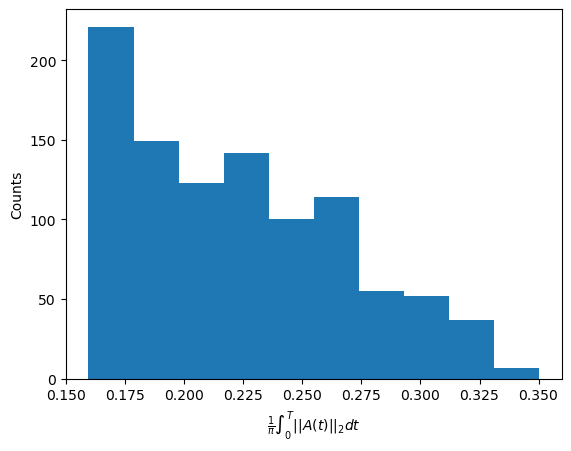

In [19]:
hist(convergence_test_min_x)
xlabel(L"\frac{1}{\pi} \int_0^T || A(t) ||_2 dt")
ylabel("Counts")
#annotate!([(0.35, 200, text("(B)"))])
#savefig("Fig_ConvergenceTestXHat.pdf")
show()